In [25]:
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
def plot_metrics(distribution: str, policy: str):
    file_path = f"../out/metrics_{distribution}_{policy}.csv"

    # Load the CSV file with the exact column names from the file
    df = pd.read_csv(file_path)

    # Calculate TTFT (Time to First Token) and ITL (Inter Token Latency)
    df["TTFT"] = df["first_scheduled_time"] - df["arrival_time"]
    df["ITL"] = df["last_token_time"] - df["first_scheduled_time"]

    # Plot TTFT and ITL
    plt.figure(figsize=(10, 6))
    plt.hist(df["TTFT"], bins=30, alpha=0.7, label="TTFT", color='blue')
    plt.hist(df["ITL"], bins=30, alpha=0.7, label="ITL", color='orange')
    plt.xlabel("Time (seconds)")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of TTFT and ITL ({distribution}, {policy})")
    plt.legend()
    # plt.show()

    # Group by 'lora_name' and calculate mean TTFT and ITL
    grouped = df.groupby("lora_name").agg({"TTFT": "mean", "ITL": "mean"}).reset_index()

    # Plot grouped TTFT and ITL for each 'lora_name'
    plt.figure(figsize=(12, 6))
    plt.bar(grouped["lora_name"], grouped["TTFT"], alpha=0.7, label="TTFT", color='blue')
    plt.bar(grouped["lora_name"], grouped["ITL"], alpha=0.7, label="ITL", color='orange', bottom=grouped["TTFT"])
    plt.xlabel("LoRA")
    plt.ylabel("Time (seconds)")
    plt.title(f"Average TTFT and ITL Grouped by LoRA ({distribution}, {policy})")
    plt.legend()
    plt.xticks(rotation=45)
    # plt.show()

    # Calculate and print mean and median
    total_latency = df["last_token_time"] - df["arrival_time"]
    mean_ttft = df["TTFT"].mean()
    median_ttft = df["TTFT"].median()
    mean_itl = df["ITL"].mean()
    median_itl = df["ITL"].median()
    mean_tl = total_latency.mean()
    median_tl = total_latency.median()

    print(f"{distribution} distribution, {policy} policy:")
    print(f"Mean TTFT: {mean_ttft:.2f}, Median TTFT: {median_ttft:.2f}")
    print(f"Mean ITL: {mean_itl:.2f}, Median ITL: {median_itl:.2f}")
    print(f"Mean total latency: {mean_tl:.2f}, Median total latency: {median_tl:.2f}")
    print("-" * 50)

uniform distribution, naive policy:
Mean TTFT: 0.87, Median TTFT: 0.74
Mean ITL: 0.86, Median ITL: 0.39
Mean total latency: 1.73, Median total latency: 1.35
--------------------------------------------------
uniform distribution, round_robin policy:
Mean TTFT: 1.58, Median TTFT: 1.10
Mean ITL: 0.78, Median ITL: 0.31
Mean total latency: 2.36, Median total latency: 2.40
--------------------------------------------------
normal distribution, naive policy:
Mean TTFT: 0.93, Median TTFT: 0.61
Mean ITL: 0.60, Median ITL: 0.37
Mean total latency: 1.53, Median total latency: 1.27
--------------------------------------------------
normal distribution, round_robin policy:
Mean TTFT: 1.37, Median TTFT: 1.12
Mean ITL: 0.57, Median ITL: 0.34
Mean total latency: 1.94, Median total latency: 1.68
--------------------------------------------------


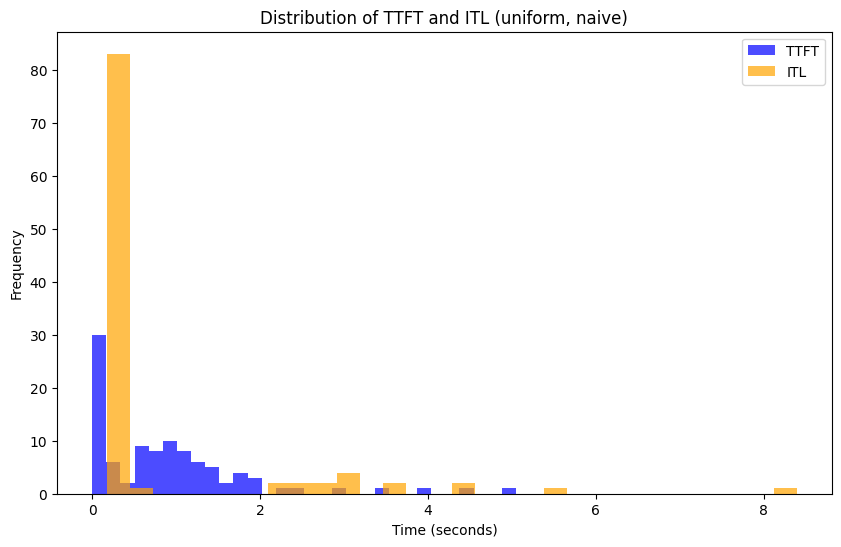

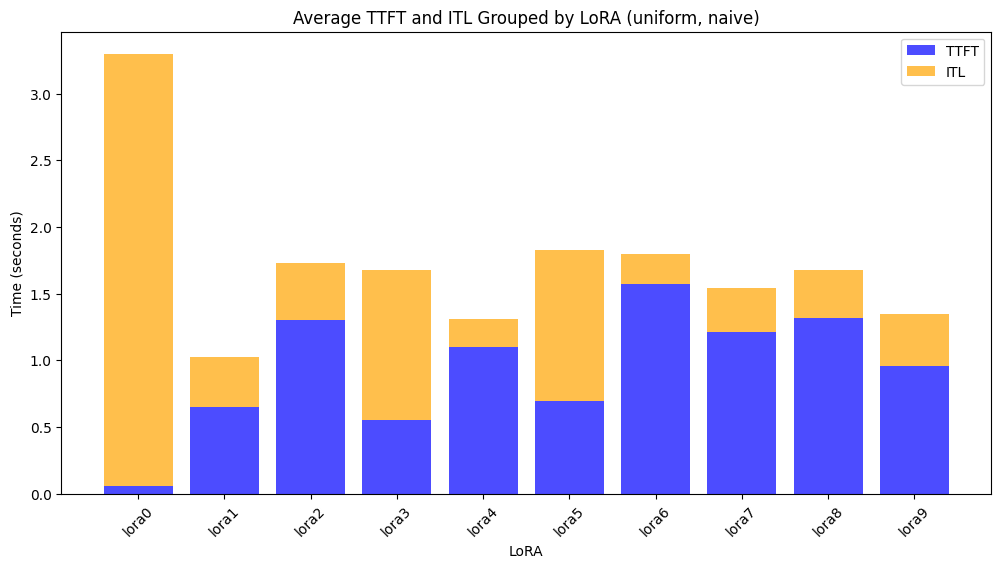

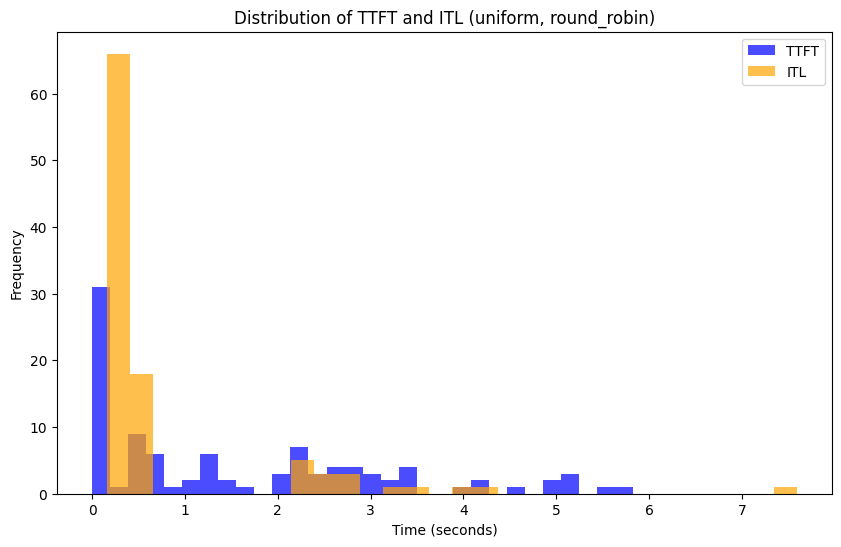

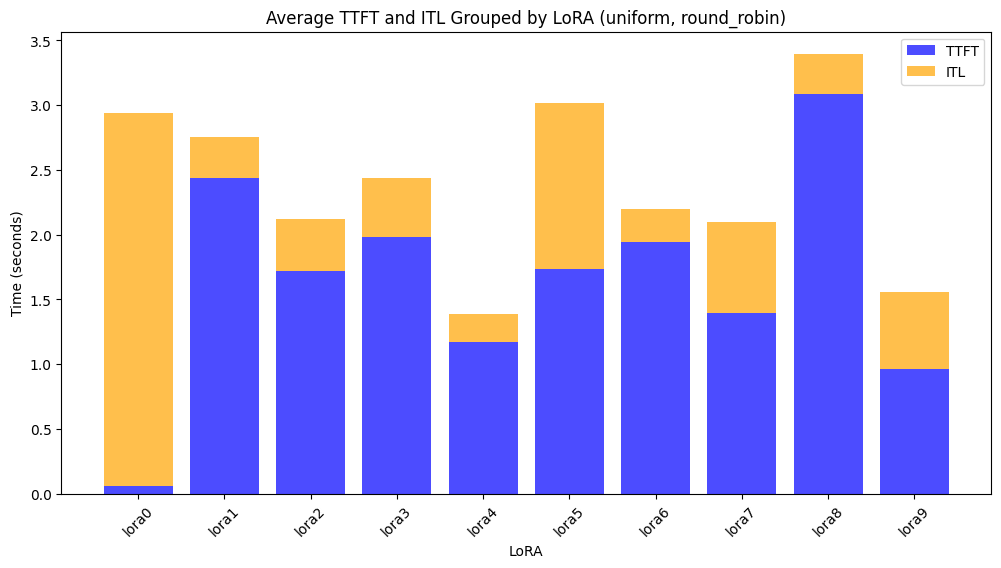

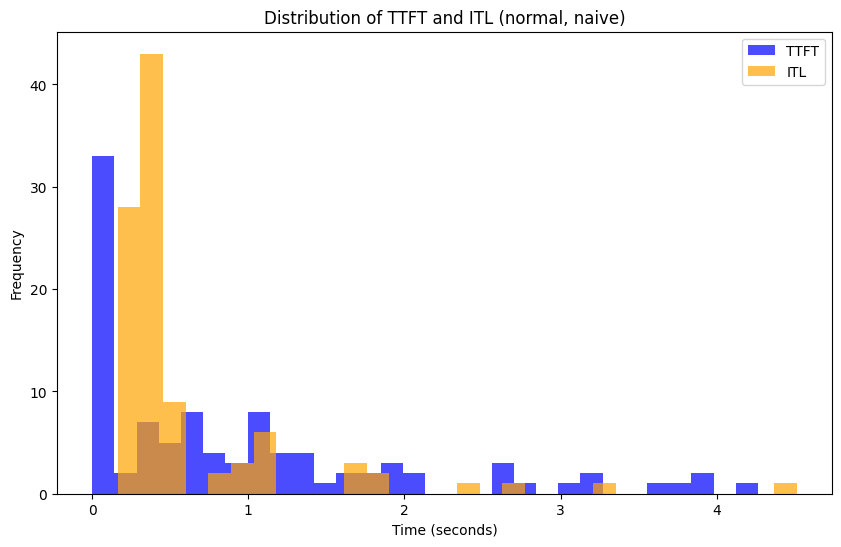

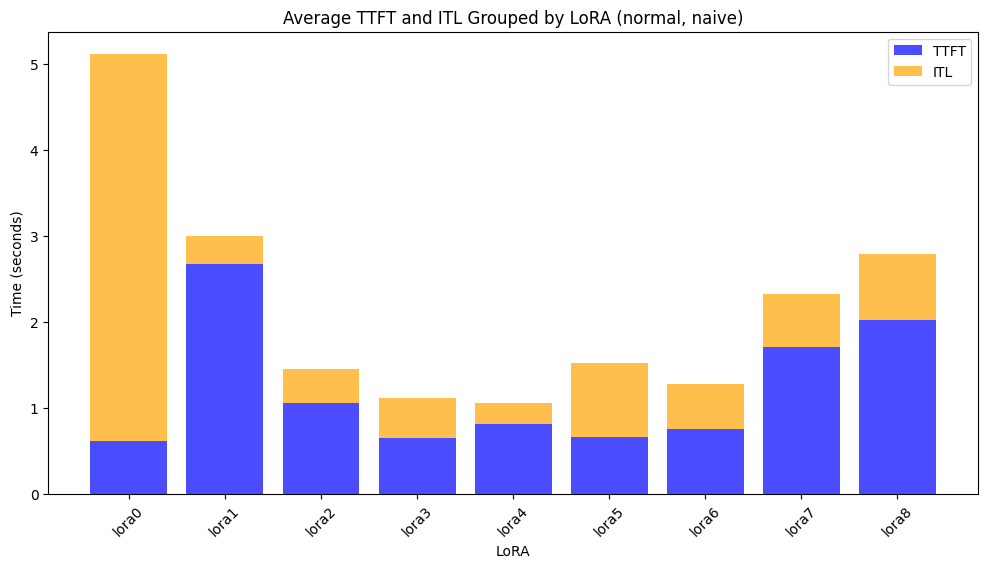

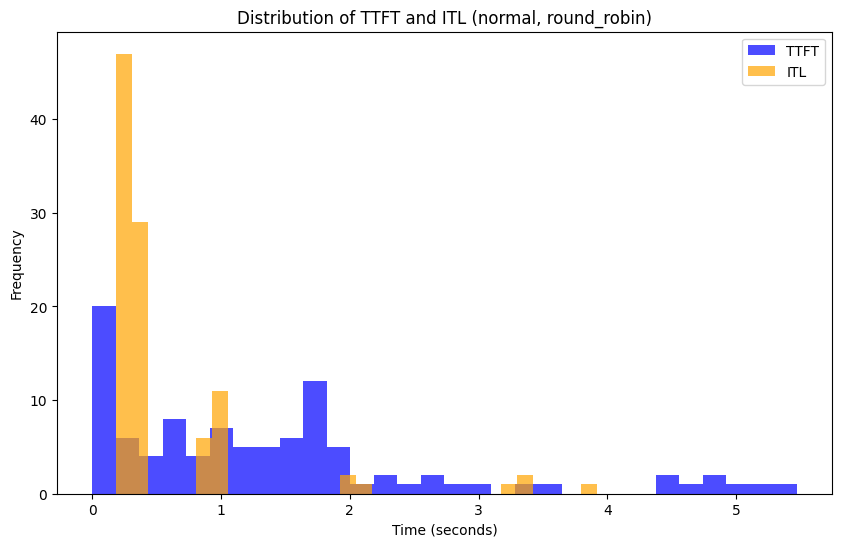

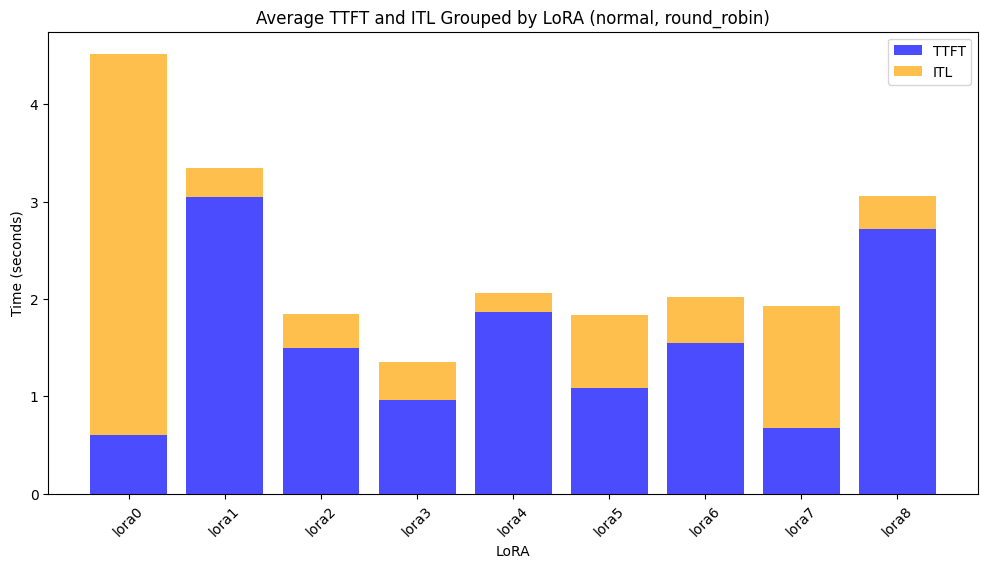

In [27]:
distributions = ["uniform", "normal"]
policies = ["naive", "round_robin"]

for distribution in distributions:
    for policy in policies:
        plot_metrics(distribution=distribution, policy=policy)

In [28]:
file_path = "../out/metrics_long.csv"
metrics_df = pd.read_csv(file_path)

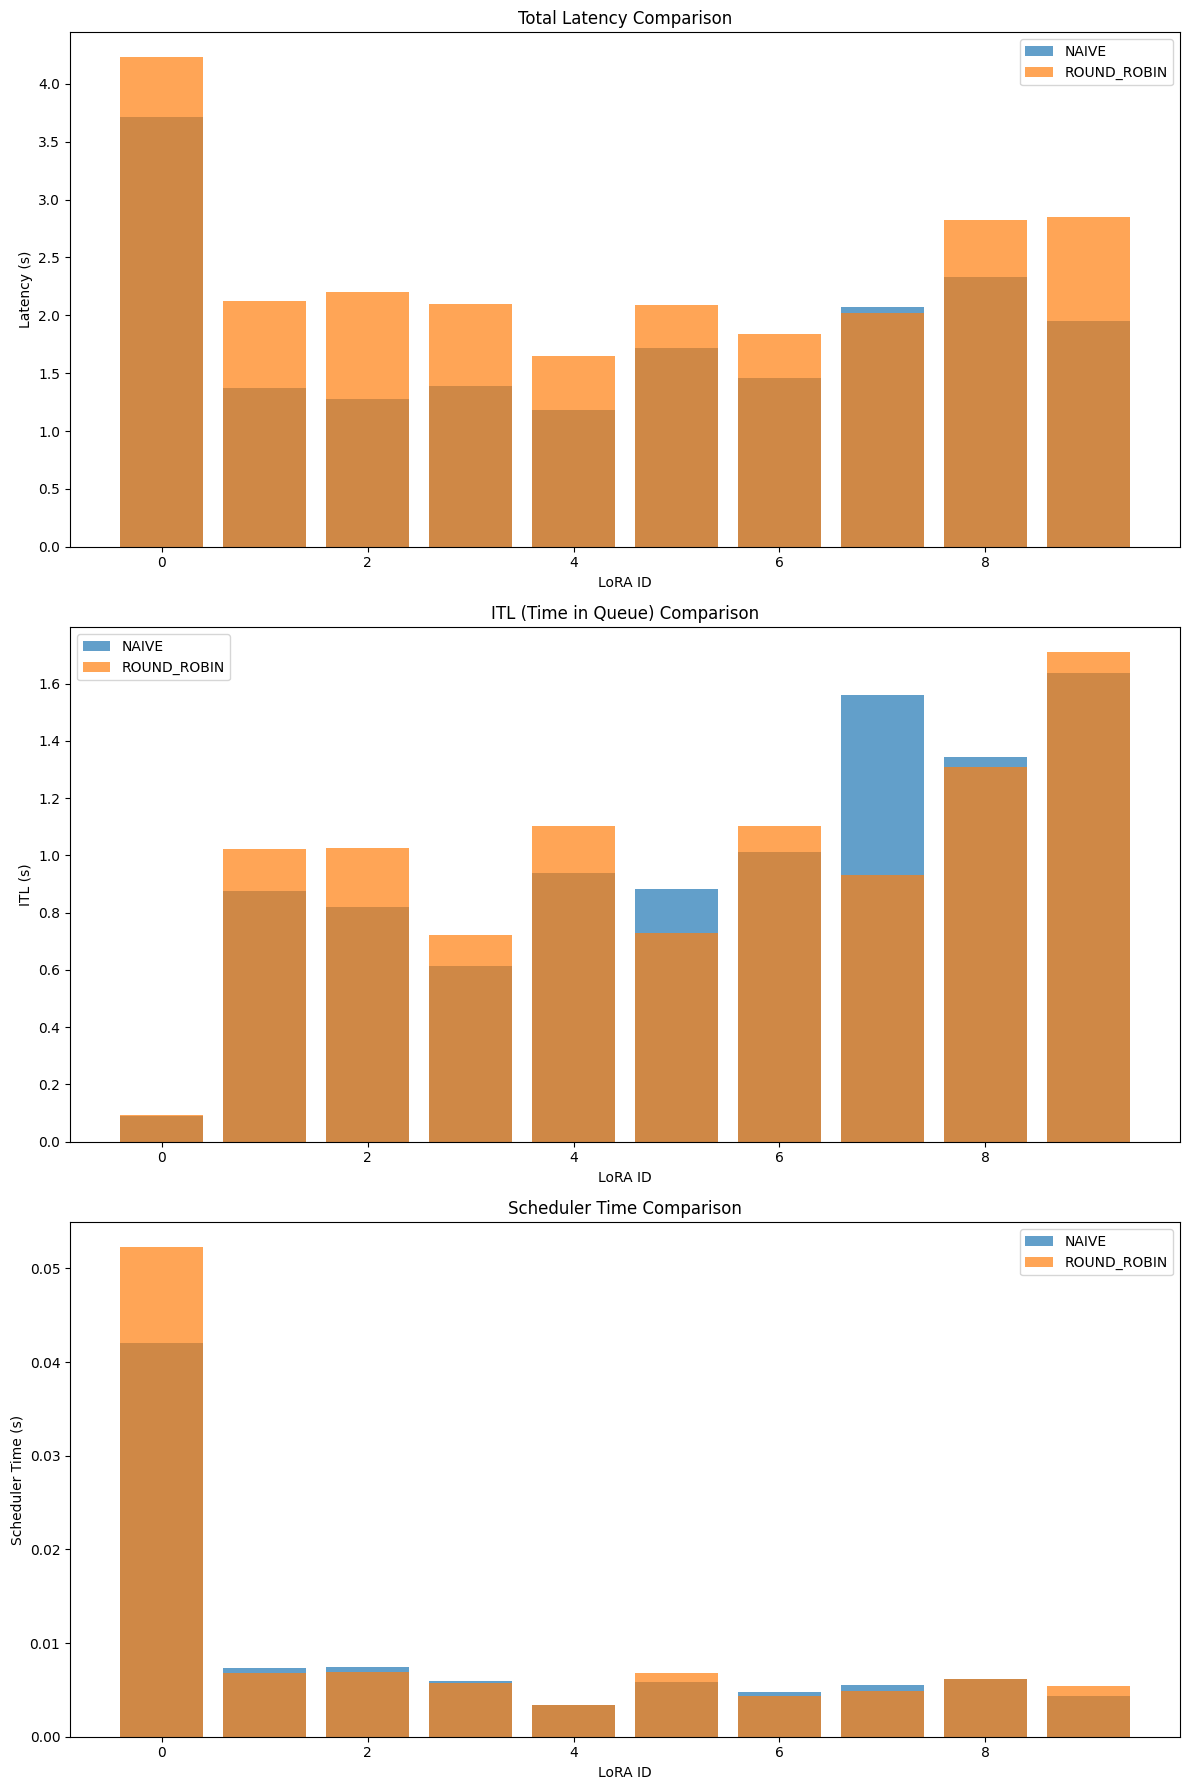

In [29]:
# Add derived metrics to the DataFrame
metrics_df['total_latency'] = metrics_df['finished_time'] - metrics_df['arrival_time']

# Group by LoRA policy and ID for summary statistics
policy_grouped = metrics_df.groupby(['lora_policy', 'lora_id']).agg({
    'total_latency': ['mean', 'std'],
    'time_in_queue': ['mean', 'std'],
    'scheduler_time': ['mean', 'std']
}).reset_index()

# Simplify column names
policy_grouped.columns = [
    'lora_policy', 'lora_id', 
    'latency_mean', 'latency_std', 
    'itl_mean', 'itl_std', 
    'scheduler_mean', 'scheduler_std'
]

# Split data for visualization
naive_data = policy_grouped[policy_grouped['lora_policy'] == 'LoraPolicy.NAIVE']
rr_data = policy_grouped[policy_grouped['lora_policy'] == 'LoraPolicy.ROUND_ROBIN']

# Plot comparison of latency, ITL, and scheduler time
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Plot Total Latency
axs[0].bar(naive_data['lora_id'], naive_data['latency_mean'], label='NAIVE', alpha=0.7)
axs[0].bar(rr_data['lora_id'], rr_data['latency_mean'], label='ROUND_ROBIN', alpha=0.7)
axs[0].set_title("Total Latency Comparison")
axs[0].set_xlabel("LoRA ID")
axs[0].set_ylabel("Latency (s)")
axs[0].legend()

# Plot ITL (Time in Queue)
axs[1].bar(naive_data['lora_id'], naive_data['itl_mean'], label='NAIVE', alpha=0.7)
axs[1].bar(rr_data['lora_id'], rr_data['itl_mean'], label='ROUND_ROBIN', alpha=0.7)
axs[1].set_title("ITL (Time in Queue) Comparison")
axs[1].set_xlabel("LoRA ID")
axs[1].set_ylabel("ITL (s)")
axs[1].legend()

# Plot Scheduler Time
axs[2].bar(naive_data['lora_id'], naive_data['scheduler_mean'], label='NAIVE', alpha=0.7)
axs[2].bar(rr_data['lora_id'], rr_data['scheduler_mean'], label='ROUND_ROBIN', alpha=0.7)
axs[2].set_title("Scheduler Time Comparison")
axs[2].set_xlabel("LoRA ID")
axs[2].set_ylabel("Scheduler Time (s)")
axs[2].legend()

plt.tight_layout()
plt.show()


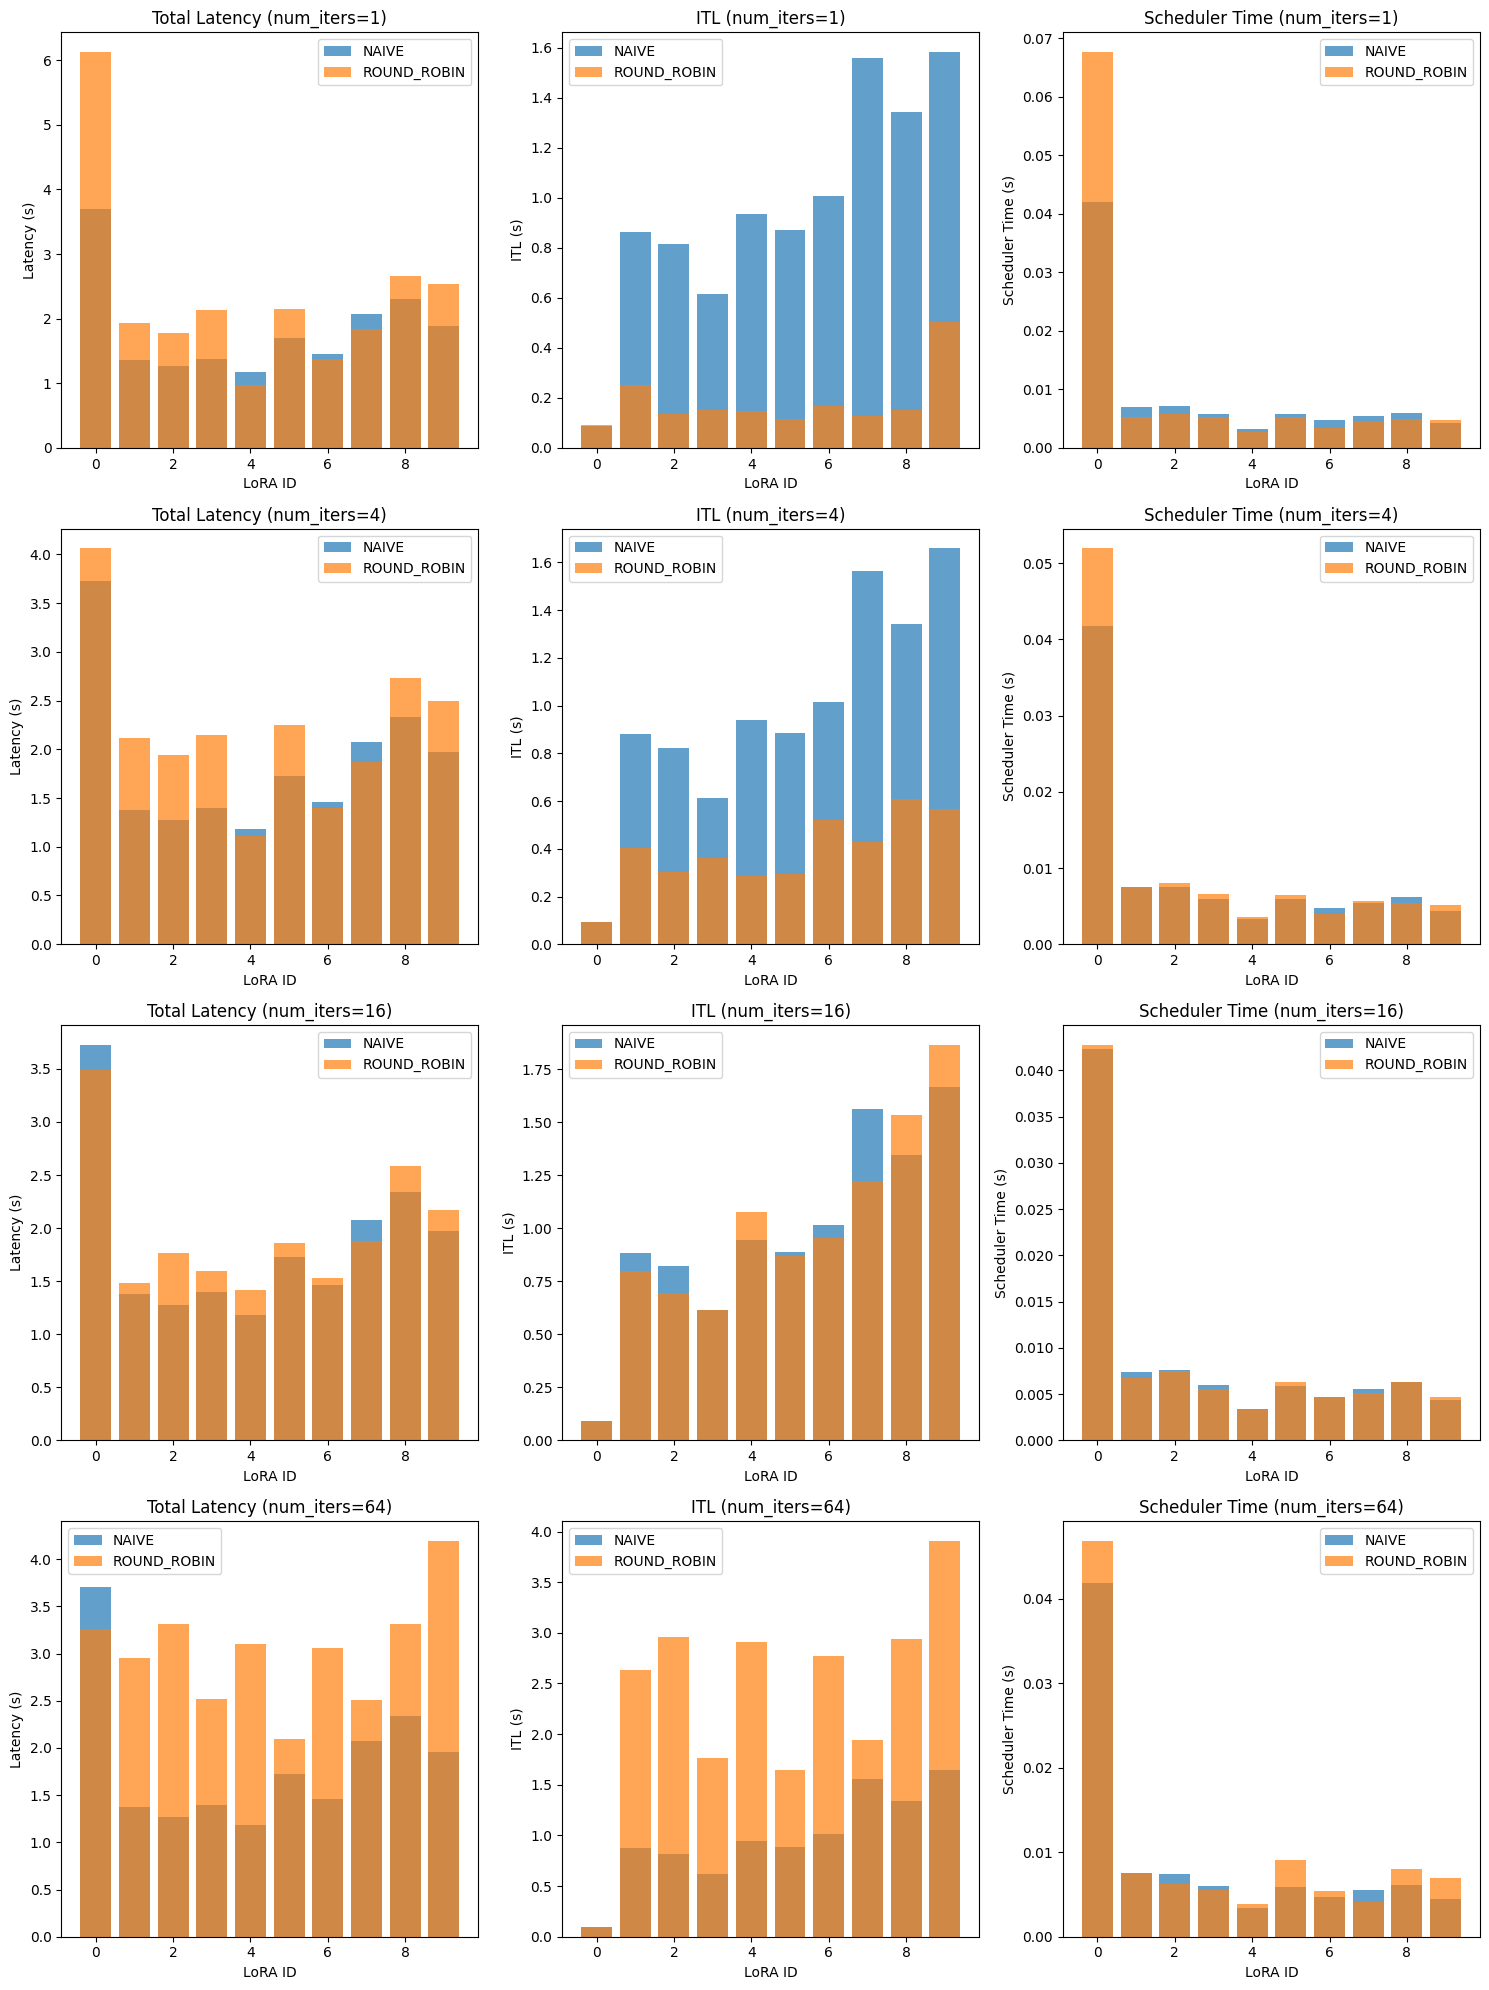

In [30]:
# Group by LoRA policy, LoRA ID, and num_iters_before_lora_reschedule
reschedule_grouped = metrics_df.groupby(
    ['lora_policy', 'lora_id', 'num_iters_before_lora_reschedule']
).agg({
    'total_latency': ['mean', 'std'],
    'time_in_queue': ['mean', 'std'],
    'scheduler_time': ['mean', 'std']
}).reset_index()

# Simplify column names
reschedule_grouped.columns = [
    'lora_policy', 'lora_id', 'num_iters_before_lora_reschedule',
    'latency_mean', 'latency_std',
    'itl_mean', 'itl_std',
    'scheduler_mean', 'scheduler_std'
]

# Plot comparisons for each num_iters_before_lora_reschedule
unique_iters = reschedule_grouped['num_iters_before_lora_reschedule'].unique()
fig, axs = plt.subplots(len(unique_iters), 3, figsize=(15, 5 * len(unique_iters)))

for idx, num_iters in enumerate(sorted(unique_iters)):
    # Filter data for the current num_iters_before_lora_reschedule
    subset = reschedule_grouped[reschedule_grouped['num_iters_before_lora_reschedule'] == num_iters]
    naive_data = subset[subset['lora_policy'] == 'LoraPolicy.NAIVE']
    rr_data = subset[subset['lora_policy'] == 'LoraPolicy.ROUND_ROBIN']

    # Total Latency
    axs[idx, 0].bar(naive_data['lora_id'], naive_data['latency_mean'], label='NAIVE', alpha=0.7)
    axs[idx, 0].bar(rr_data['lora_id'], rr_data['latency_mean'], label='ROUND_ROBIN', alpha=0.7)
    axs[idx, 0].set_title(f"Total Latency (num_iters={num_iters})")
    axs[idx, 0].set_xlabel("LoRA ID")
    axs[idx, 0].set_ylabel("Latency (s)")
    axs[idx, 0].legend()

    # ITL (Time in Queue)
    axs[idx, 1].bar(naive_data['lora_id'], naive_data['itl_mean'], label='NAIVE', alpha=0.7)
    axs[idx, 1].bar(rr_data['lora_id'], rr_data['itl_mean'], label='ROUND_ROBIN', alpha=0.7)
    axs[idx, 1].set_title(f"ITL (num_iters={num_iters})")
    axs[idx, 1].set_xlabel("LoRA ID")
    axs[idx, 1].set_ylabel("ITL (s)")
    axs[idx, 1].legend()

    # Scheduler Time
    axs[idx, 2].bar(naive_data['lora_id'], naive_data['scheduler_mean'], label='NAIVE', alpha=0.7)
    axs[idx, 2].bar(rr_data['lora_id'], rr_data['scheduler_mean'], label='ROUND_ROBIN', alpha=0.7)
    axs[idx, 2].set_title(f"Scheduler Time (num_iters={num_iters})")
    axs[idx, 2].set_xlabel("LoRA ID")
    axs[idx, 2].set_ylabel("Scheduler Time (s)")
    axs[idx, 2].legend()

plt.tight_layout()
plt.show()